<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Yield Curve Fitting of Italian Bonds - Nelson Siegel Model

In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from MachineTrading.AlgoTradingApp.app_run import AppBond
from MachineTrading.Utils.pnl_calculator import PnLCalculator, compute_pnl
from prettytable import PrettyTable
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.ticker as mtick

In [2]:
BTP_ISINS = [x.split('.')[0] for x in os.listdir("../AlgoTradingApp/Data/BondInfo") if 'IT0' in x]

In [3]:
bonds = {x:AppBond(x) for x in BTP_ISINS}

In [4]:
for isin, b in bonds.items():
    b.update_data(dt.date(2022,3,23))

Calling - update_data for isin IT0005217390
Calling - update_data for isin IT0005365165
Calling - update_data for isin IT0005377152
Calling - update_data for isin IT0005390874
Calling - update_data for isin IT0005408502
Calling - update_data for isin IT0005413171
Calling - update_data for isin IT0005424251
Calling - update_data for isin IT0005425233
Calling - update_data for isin IT0005433195
Calling - update_data for isin IT0005433690
Calling - update_data for isin IT0005440679
Calling - update_data for isin IT0005441719
Calling - update_data for isin IT0005447187
Calling - update_data for isin IT0005449969
Calling - update_data for isin IT0005454241
Calling - update_data for isin IT0005466013
Calling - update_data for isin IT0005482937
Calling - update_data for isin IT0005486748


In [5]:
data = []
for isin, b in bonds.items():
    data.append((isin, b.years_to_maturity , b.yld))

In [6]:
data = sorted(data, key=lambda x: x[1])

In [7]:
data = pd.DataFrame(data)
data.columns = ['Isin', 'Maturity', 'Yield']

In [8]:
def nelson_siegel(T, tau, b0, b1, b2):
    x = T/tau
    return b0 + b1* (1-np.exp(-x))/x + b2*((1-np.exp(-x))/x - np.exp(-x))        

In [9]:
popt, pcov = curve_fit(nelson_siegel, data['Maturity'].values, data['Yield'].values)

In [19]:
data['NS'] = nelson_siegel(data['Maturity'].values, popt[0], popt[1], popt[2], popt[3])
data['Residual'] = data['NS']-data['Yield']
data['ResidualPercentage'] = data['Residual']/np.abs(data['Yield'])*100

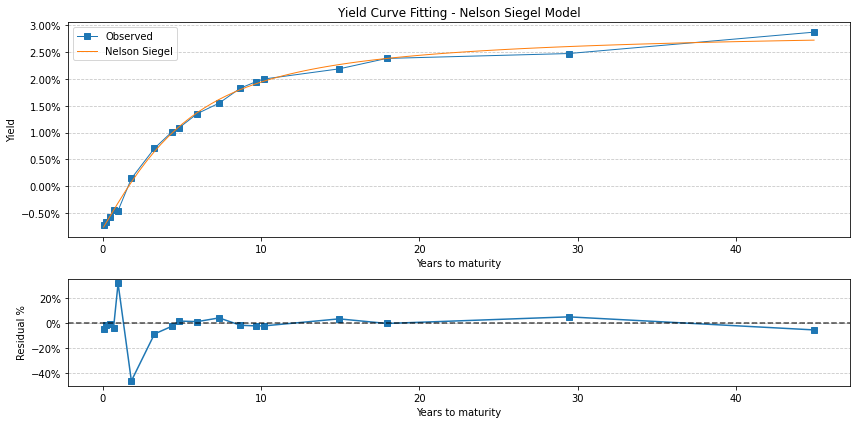

In [25]:
x = data['Maturity'].values
y =  data['Yield'].values*100

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = nelson_siegel(x2, popt[0], popt[1], popt[2], popt[3])*100

fig, axes = plt.subplots(figsize=(12,6), nrows=2, gridspec_kw={'height_ratios': [2, 1]})

axes[0].plot(x, y, 's-', label='Observed', alpha=1.0, lw=1)
axes[0].plot(x2, y2, label='Nelson Siegel', lw=1)

axes[0].grid(axis='y', alpha=0.7, ls='--')
axes[0].legend()
axes[0].set_title("Yield Curve Fitting - Nelson Siegel Model")
axes[0].set_xlabel("Years to maturity")
axes[0].set_ylabel("Yield")
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())

axes[1].plot(x, data['ResidualPercentage'], 's-', label='Residuals', alpha=1.0)
axes[1].set_xlabel("Years to maturity")
axes[1].set_ylabel("Residual %")
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[1].grid(axis='y', alpha=0.7, ls='--')
axes[1].axhline(0, ls='--', color='k', alpha=0.7)

plt.tight_layout()
plt.show()

In [67]:
yields = np.linspace(-0.08, 0.12, 100)
yield_variation = []
for y in yields:
    p = bonds['IT0005449969'].bond.clean_price(bond_yield=y)
    yield_variation.append((y, p))
yield_variation = np.array(yield_variation)

In [68]:
def straight_line(x, m, n):
    y = m*x+n
    return y

In [69]:
popt_sl, pcov_sl = curve_fit(straight_line, yield_variation[45:55][:,0], yield_variation[45:55][:,1])

In [70]:
st_yld = np.linspace(yield_variation[:,0][0], yield_variation[:,0][-1])
st_price = straight_line(st_yld, popt_sl[0], popt_sl[1])

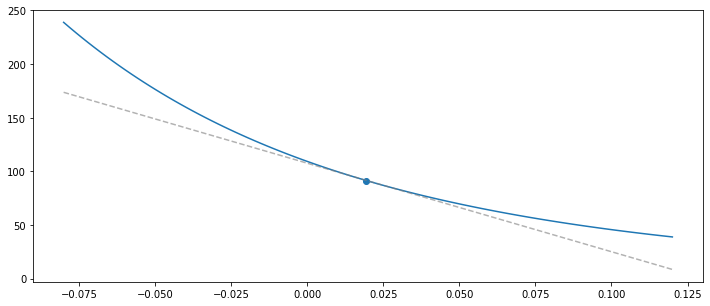

In [71]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(yield_variation[:,0], yield_variation[:,1])
ax.plot(st_yld, st_price, ls='--', color='grey', alpha=0.6)
ax.scatter([bonds['IT0005449969'].yld], [bonds['IT0005449969'].price])